# Malaria Cell Image Classification 

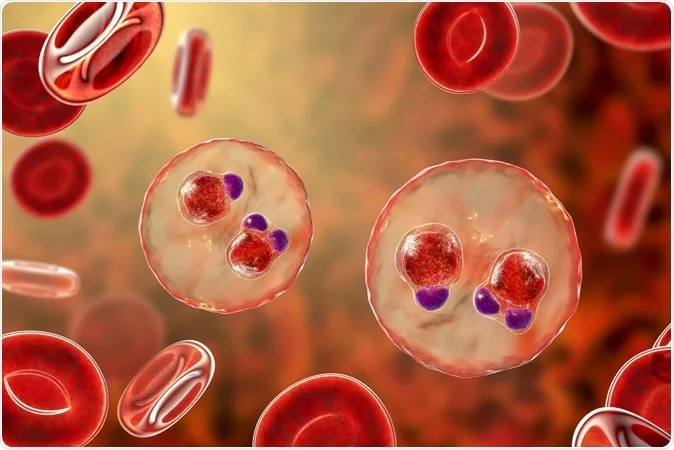

In [ ]:
# First we import the necessary libraries


import torch
!pip install timm # This is a third-party library. We just use this because the BiT-M model is already defined in this.
!pip install torchmetrics # We use this to compute common metrics such as average and accuracy without having to write the code ourselves.
import torchmetrics
import timm
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 4.5 MB/s 
     |████████████████████████████████| 163 kB 82.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.7 MB/s 


In [ ]:
model = timm.create_model('resnetv2_50x1_bitm',pretrained=True, num_classes=2) # We are creating the model here.

In [ ]:
#Upload zip file with image data.
#Existing zip files are cleared first to avoid file name clashes  
from google.colab import files
!rm /content/*.zip
uploaded = files.upload()

Accessing to my google drive (data is there):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip images (delete folder images in case it exists)
!rm -r cell_images
!unzip /content/drive/MyDrive/cell_images.zip -d /content/ # I used my google drive, so for uploading part change it to !unzip /content/images.zip -d /content/


In [ ]:
#Fine-tune this model using BiT-HyperRule 
image_size = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
#Alternatively, set image_size = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
dataset_size = "20k-500k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]
#Resize and crop images
if image_size == "=<96x96 px":
  resize_to = 160
  crop_to = 128
else:
  resize_to = 512
  crop_to = 480
#Training steps
if dataset_size == "<20k examples":
  schedule_length = 500
  schedule_boundaries = [200, 300, 400]
elif dataset_size == "20k-500k examples":
  schedule_length = 10000
  schedule_boundaries = [3000, 6000, 9000]
else:
  schedule_length = 20000
  schedule_boundaries = [6000, 12000, 18000]





#Preprocessing
batch_size = 16
schedule_length = schedule_length * 512 / batch_size
steps_per_epoch= 16
lr = 0.005 * batch_size / 512


In [ ]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=(resize_to, resize_to)),
    transforms.RandomCrop(size=(crop_to, crop_to)),
    transforms.transforms.ToTensor()
]
)

transforms_test = transforms.Compose([
    transforms.Resize(size=(crop_to, crop_to)),
    transforms.ToTensor()
]
)

train_dataset = DataLoader(ImageFolder(root='/content/cell_images/train', transform=transforms_train), batch_size=batch_size)
test_dataset = DataLoader(ImageFolder(root='/content/cell_images/test', transform=transforms_test), batch_size=batch_size)

Getting different batches from train dataset:

In [78]:
for step, (x,y) in enumerate(train_dataset):
  if step == 0:
    batch_1 = (x,y)
  if step == 695:
    batch_1000 = (x,y)
    break;
images_1, labels_1 = batch_1
images_1000 , labels_1000 = batch_1000    


Uninfected from first batch (class 1):

labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


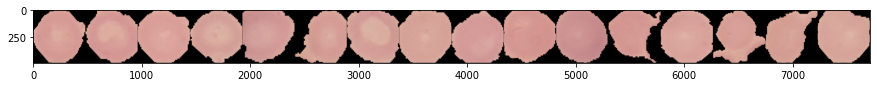

In [80]:
grid_1 = torchvision.utils.make_grid(images_1, nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid_1, (1,2,0)))
print('labels:', labels_1)

Parasitized (class 2) from 1000th batch:

labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


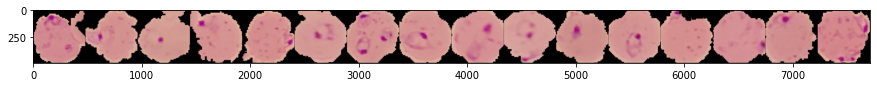

In [81]:
grid_1000 =torchvision.utils.make_grid(images_1000, nrow=16) 
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid_1000, (1,2,0)))
print('labels:', labels_1000)

Epoch[1/30]: loss_train=0.0095, loss_test=3.6066,  accuracy_train=0.998, accuracy_test=0.500
Epoch[2/30]: loss_train=0.0131, loss_test=3.2399,  accuracy_train=0.997, accuracy_test=0.500
Epoch[3/30]: loss_train=0.0338, loss_test=1.7528,  accuracy_train=0.988, accuracy_test=0.500
Epoch[4/30]: loss_train=0.0436, loss_test=1.7027,  accuracy_train=0.983, accuracy_test=0.500
Epoch[5/30]: loss_train=0.5518, loss_test=0.3208,  accuracy_train=0.765, accuracy_test=0.882
Epoch[6/30]: loss_train=0.2754, loss_test=0.2053,  accuracy_train=0.902, accuracy_test=0.937
Epoch[7/30]: loss_train=0.2312, loss_test=0.2064,  accuracy_train=0.924, accuracy_test=0.937
Epoch[8/30]: loss_train=0.2252, loss_test=0.2017,  accuracy_train=0.927, accuracy_test=0.937
Epoch[9/30]: loss_train=0.2199, loss_test=0.1974,  accuracy_train=0.927, accuracy_test=0.939
Epoch[10/30]: loss_train=0.2169, loss_test=0.1935,  accuracy_train=0.929, accuracy_test=0.941
Epoch[11/30]: loss_train=0.2124, loss_test=0.1900,  accuracy_train=0.

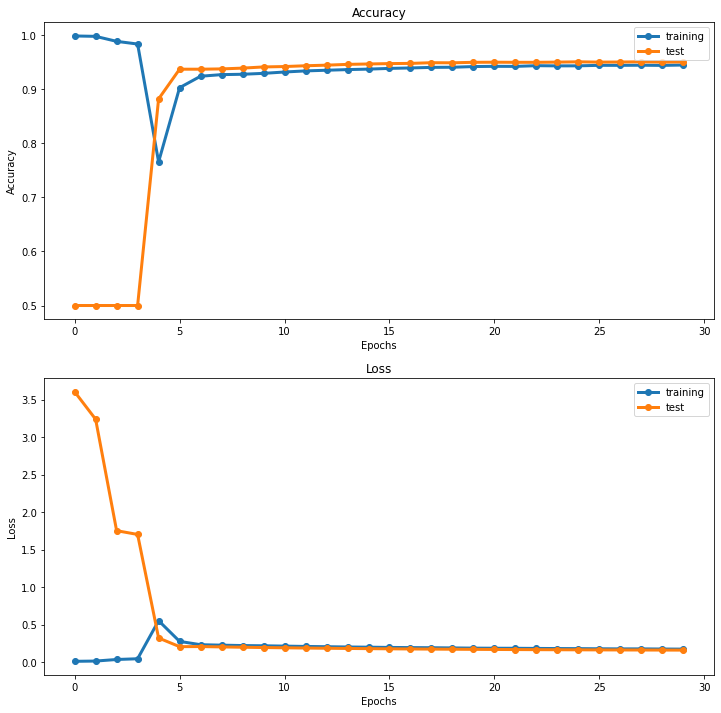

In [11]:
def get_lr(steps):
  if steps<=schedule_boundaries[0]:
    return lr 
  elif steps<=schedule_boundaries[1]:
    return lr * 0.1
  elif steps<=schedule_boundaries[2]:
    return lr*0.001
  else:
    return lr*0.0001

TRAIN_LOSS = list()
TEST_LOSS = list()
TRAIN_ACCURACY = list()
TEST_ACCURACY = list()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_STEPS = 0
avg_loss_metric_train = torchmetrics.MeanMetric().to(device)
accuracy_metric_train = torchmetrics.Accuracy().to(device)
avg_loss_metric_test = torchmetrics.MeanMetric().to(device)
accuracy_metric_test = torchmetrics.Accuracy().to(device)
model.to(device)
model.train()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
for epoch in range(30):
  for img_tensor, label_tensor in train_dataset:
    img_tensor = img_tensor.to(device)
    label_tensor = label_tensor.to(device)
    optimizer.zero_grad()
    output_logits = model(img_tensor)
    loss_val = loss_fn(output_logits, label_tensor)
    loss_val.backward()
    current_learning_rate = get_lr(NUM_STEPS)
    for g in optimizer.param_groups:
      g['lr'] = current_learning_rate
    optimizer.step()
    avg_loss_metric_train.update(loss_val)
    accuracy_metric_train.update(output_logits, label_tensor)
    NUM_STEPS+=1
  
  model.eval()
  for img_tensor, label_tensor in test_dataset:
    img_tensor = img_tensor.to(device)
    label_tensor = label_tensor.to(device)
    output_logits=model(img_tensor)
    loss_val = loss_fn(output_logits, label_tensor)
    avg_loss_metric_test.update(loss_val)
    accuracy_metric_test.update(output_logits, label_tensor)
  
  TRAIN_LOSS.append(avg_loss_metric_train.compute().cpu().numpy()) 
  TEST_LOSS.append(avg_loss_metric_test.compute().cpu().numpy())
  TRAIN_ACCURACY.append(accuracy_metric_train.compute().cpu().numpy())
  TEST_ACCURACY.append(accuracy_metric_test.compute().cpu().numpy())
  print('Epoch[{}/30]: loss_train={:.4f}, loss_test={:.4f},  accuracy_train={:.3f}, accuracy_test={:.3f}'.format(epoch+1, TRAIN_LOSS[-1],
                                                                                                                 TEST_LOSS[-1],
                                                                                                                 TRAIN_ACCURACY[-1],
                                                                                                                 TEST_ACCURACY[-1]
                                                                                                                 ))
  avg_loss_metric_train.reset()
  accuracy_metric_train.reset()
  avg_loss_metric_test.reset()
  accuracy_metric_test.reset()

  
def learning_curve(lw = 3):
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    plt.plot(TRAIN_ACCURACY, label = 'training', marker = 'o', linewidth = lw)
    plt.plot(TEST_ACCURACY, label = 'test', marker = 'o', linewidth = lw)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    

    plt.subplot(2,1,2)
    plt.plot(TRAIN_LOSS, label = 'training', marker = 'o', linewidth = lw)
    plt.plot(TEST_LOSS, label = 'test', marker = 'o', linewidth = lw)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


learning_curve()








"While doing experiments on the malaria dataset, we found that certain samples were mislabeled. These mislabeled samples were corrected and the corrections can be found in [41] for future research."

Reference: 
Fuhad KMF, Tuba JF, Sarker MRA, Momen S, Mohammed N, Rahman T. Deep Learning Based Automatic Malaria Parasite Detection from Blood Smear and its Smartphone Based Application. Diagnostics (Basel). 2020;10(5):329. Published 2020 May 20. doi:10.3390/diagnostics10050329

Dataset is achieved from kaggle datasets download -d iarunava/cell-images-for-detecting-malaria (approved from original website): https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html

Image is achieved from https://www.news-medical.net/news/20200219/How-malaria-evades-the-bodys-immune-response.aspx